In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tqdm import tqdm
from scipy import stats
from scipy import stats as sp
from scipy.optimize import fminbound
from sklearn import preprocessing
from scipy.stats import chi2_contingency

In [124]:
file_path = "./dataset_new/"
retail_data_ar= pd.read_csv(f"{file_path}Retail_data_add_region.csv")
industry_data_ar = pd.read_csv(f"{file_path}Industry_data_add_region.csv")

### industry data > retail data 를 확인하기 위해서 store-item-Datetime 열을 생성한다

In [125]:

retail_si = []
for i in tqdm(range(len(retail_data_ar))):
    store = retail_data_ar.loc[i]['Store']
    item = retail_data_ar.loc[i]['Item']
    year = retail_data_ar.loc[i]["Year"]
    month = retail_data_ar.loc[i]["Month"]
    retail_si.append(f'{store}-{item}-{year}-{month}')

100%|██████████| 125226/125226 [00:49<00:00, 2542.95it/s]


In [126]:
retail_data_ar['StoreItem'] = retail_si


In [127]:
industry_si = []
for i in tqdm(range(len(industry_data_ar))):
    store = industry_data_ar.loc[i]['Store']
    item = industry_data_ar.loc[i]['Item']
    year = industry_data_ar.loc[i]["Year"]
    month = industry_data_ar.loc[i]["Month"]
    industry_si.append(f'{store}-{item}-{year}-{month}')
    
industry_data_ar['StoreItem'] = industry_si


100%|██████████| 352894/352894 [02:18<00:00, 2555.83it/s]


In [128]:
retail_data_ar

,Sales Total,Store,Product Type,Item,Year,Month,Datetime,Region Level 1,Region Level 2,Urban/Rural,StoreItem
0,1,1,Electronics,Phone Charger,2021,2,2021-02-01,Eisenstadt-Umgebung,GWR,Urban,1-Phone Charger-2021-2
1,5,1,Grocery,Shrimp,2021,2,2021-02-01,Eisenstadt-Umgebung,GWR,Urban,1-Shrimp-2021-2
2,2,1,Grocery,Noodles,2021,2,2021-02-01,Eisenstadt-Umgebung,GWR,Urban,1-Noodles-2021-2
3,1,1,Grocery,King Crab,2021,2,2021-02-01,Eisenstadt-Umgebung,GWR,Urban,1-King Crab-2021-2
4,1,1,Electronics,Ear Buds,2021,3,2021-03-01,Eisenstadt-Umgebung,GWR,Urban,1-Ear Buds-2021-3
...,...,...,...,...,...,...,...,...,...,...,...
125221,1,642,Electronics,Ear Buds,2021,7,2021-07-01,Koillismaa,KTR,Urban,642-Ear Buds-2021-7
125222,0,642,Electronics,Power Cord,2021,8,2021-08-01,Koillismaa,KTR,Urban,642-Power Cord-2021-8
125223,0,642,Home Goods,Nails,2021,9,2021-09-01,Koillismaa,KTR,Urban,642-Nails-2021-9
125224,1,642,Electronics,Keyboard,2022,2,2022-02-01,Koillismaa,KTR,Urban,642-Keyboard-2022-2


In [129]:
industry_data_ar

,Industry Size,Store,Product Type,Item,Year,Month,Datetime,Region Level 1,Region Level 2,Urban/Rural,StoreItem
0,2,1,Electronics,Keyboard,2015,1,2015-01-01,Eisenstadt-Umgebung,GWR,Urban,1-Keyboard-2015-1
1,1,1,Grocery,Steak,2015,1,2015-01-01,Eisenstadt-Umgebung,GWR,Urban,1-Steak-2015-1
2,1,1,Home Goods,Paint,2015,1,2015-01-01,Eisenstadt-Umgebung,GWR,Urban,1-Paint-2015-1
3,1,1,Grocery,Shrimp,2015,2,2015-02-01,Eisenstadt-Umgebung,GWR,Urban,1-Shrimp-2015-2
4,2,1,Electronics,Phone Charger,2015,3,2015-03-01,Eisenstadt-Umgebung,GWR,Urban,1-Phone Charger-2015-3
...,...,...,...,...,...,...,...,...,...,...,...
352889,1,642,Grocery,Noodles,2022,3,2022-03-01,Koillismaa,KTR,Urban,642-Noodles-2022-3
352890,1,642,Grocery,King Crab,2022,3,2022-03-01,Koillismaa,KTR,Urban,642-King Crab-2022-3
352891,1,642,Home Goods,Glue,2022,3,2022-03-01,Koillismaa,KTR,Urban,642-Glue-2022-3
352892,1,642,Home Goods,Nails,2022,3,2022-03-01,Koillismaa,KTR,Urban,642-Nails-2022-3


In [130]:
# retail_err_idx = []
# industry_err_idx = []
# retail_err_fix = {} # {index : 작은 값}

industry_err_fix = {}
industry_err_add = []

In [131]:
for i in tqdm(range(len(retail_data_ar))):
    storeitem = retail_data_ar.loc[i]['StoreItem']
    same_item_df = industry_data_ar[industry_data_ar['StoreItem']==storeitem]
    if len(same_item_df) == 0: # # industry data에 없으면 ?
        industry_err_add.append(retail_data_ar.loc[i]) # retail data에 값이 없으면 industry data에 retail data값을 넣어줌
        #retail_err_idx.append(i) 
        #retail_err_fix[i] = 0 # industry에 값이 없으므로 retail 데이터 값을 0으로 바꿔줄 예정
        
        #industry_err_idx.append(same_item_df.index[0])
        continue
    
    if same_item_df.iloc[0]['Industry Size'] < retail_data_ar.loc[i]["Sales Total"]: # Sales total이 더 크면 error
        #retail_err_idx.append(i)
        #industry_err_idx.append(same_item_df.index[0])
        industry_err_fix[same_item_df.index[0]] = retail_data_ar.loc[i]["Sales Total"] # industry_data 값을 retail_data 값으로 바꿔줌

100%|██████████| 125226/125226 [46:47<00:00, 44.61it/s]


In [132]:
import pickle
# with open('retail_err_idx.pkl','wb') as f:
#     pickle.dump(retail_err_idx,f)
# with open('industry_err_idx.pkl','wb') as f:
#     pickle.dump(industry_err_idx,f)
with open('industry_err_fix.pkl','wb') as f:
    pickle.dump(industry_err_fix,f)
with open('industry_err_add.pkl','wb') as f:
    pickle.dump(industry_err_add,f)

# with open('retail_err_idx.pkl','rb') as f:
#     retail_err_idx = pickle.load(f)
# with open('industry_err_idx.pkl', 'rb') as f:
#     industry_err_idx = pickle.load(f)
with open('industry_err_fix.pkl', 'rb') as f:
    industry_err_fix = pickle.load(f)
with open('industry_err_add.pkl', 'rb') as f:
    industry_err_add = pickle.load(f)

In [133]:
print(len(industry_err_fix))
print(len(industry_err_add))

4205
19196


In [134]:
for i in industry_err_fix:
    industry_data_ar.loc[i,"Industry Size"] = industry_err_fix[i]
industry_data_ar.loc[615] # 값 바뀐거 확인됨

Industry Size                       3
Store                               1
Product Type              Electronics
Item                         Keyboard
Year                             2021
Month                               5
Datetime                   2021-05-01
Region Level 1    Eisenstadt-Umgebung
Region Level 2                    GWR
Urban/Rural                     Urban
StoreItem           1-Keyboard-2021-5
Name: 615, dtype: object

In [135]:
industry_data_ar

,Industry Size,Store,Product Type,Item,Year,Month,Datetime,Region Level 1,Region Level 2,Urban/Rural,StoreItem
0,2,1,Electronics,Keyboard,2015,1,2015-01-01,Eisenstadt-Umgebung,GWR,Urban,1-Keyboard-2015-1
1,1,1,Grocery,Steak,2015,1,2015-01-01,Eisenstadt-Umgebung,GWR,Urban,1-Steak-2015-1
2,1,1,Home Goods,Paint,2015,1,2015-01-01,Eisenstadt-Umgebung,GWR,Urban,1-Paint-2015-1
3,1,1,Grocery,Shrimp,2015,2,2015-02-01,Eisenstadt-Umgebung,GWR,Urban,1-Shrimp-2015-2
4,2,1,Electronics,Phone Charger,2015,3,2015-03-01,Eisenstadt-Umgebung,GWR,Urban,1-Phone Charger-2015-3
...,...,...,...,...,...,...,...,...,...,...,...
352889,1,642,Grocery,Noodles,2022,3,2022-03-01,Koillismaa,KTR,Urban,642-Noodles-2022-3
352890,1,642,Grocery,King Crab,2022,3,2022-03-01,Koillismaa,KTR,Urban,642-King Crab-2022-3
352891,1,642,Home Goods,Glue,2022,3,2022-03-01,Koillismaa,KTR,Urban,642-Glue-2022-3
352892,1,642,Home Goods,Nails,2022,3,2022-03-01,Koillismaa,KTR,Urban,642-Nails-2022-3


In [136]:
for i in industry_err_add:
    industry_data_ar.loc[len(industry_data_ar)+1] = i.rename({'Sales Total':'Industry Size'})

In [137]:
retail_data_ar_delidx = retail_data_ar[['Sales Total','Store', 'Product Type', 'Item','Year','Month','Datetime','Region Level 1','Region Level 2','Urban/Rural']]
industry_data_ar_delidx = industry_data_ar[['Industry Size','Store', 'Product Type', 'Item','Year','Month','Datetime','Region Level 1','Region Level 2','Urban/Rural']]

In [142]:
industry_data_ar.to_csv('industry_data_min.csv',index=False)
retail_data_ar.to_csv('retail_data_min.csv',index=False)

In [138]:
# Label encoding

label = preprocessing.LabelEncoder()
retail_data_encoded = pd.DataFrame()
industry_data_encoded = pd.DataFrame()

for i in retail_data_ar_delidx.columns:
    retail_data_encoded[i] = label.fit_transform(retail_data_ar_delidx[i])

for i in industry_data_ar_delidx.columns:
    industry_data_encoded[i] = label.fit_transform(industry_data_ar_delidx[i])

In [139]:
def cramers_V(var1, var2):
    crosstab = np.array(pd.crosstab(var1, var2, rownames=None, colnames=None))  # Cross table building
    stat = chi2_contingency(crosstab)[0]  # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab)  # Number of observations
    mini = min(crosstab.shape) - 1  # Take the minimum value between the columns and the rows of the cross table
    return stat / (obs * mini)

In [140]:
# building of the matrix
rows = []

for var1 in retail_data_encoded:
    col = []
    for var2 in retail_data_encoded:
        cramers = cramers_V(retail_data_encoded[var1], retail_data_encoded[var2])  # Cramer's V test
        col.append(round(cramers, 2))  # Keeping of the rounded value of the Cramer's V
    rows.append(col)

cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns=retail_data_encoded.columns, index=retail_data_encoded.columns)

rows = []

for var1 in industry_data_encoded:
    col = []
    for var2 in industry_data_encoded:
        cramers = cramers_V(industry_data_encoded[var1], industry_data_encoded[var2])  # Cramer's V test
        col.append(round(cramers, 2))  # Keeping of the rounded value of the Cramer's V
    rows.append(col)

cramers_results = np.array(rows)
df2 = pd.DataFrame(cramers_results, columns=industry_data_encoded.columns, index=industry_data_encoded.columns)

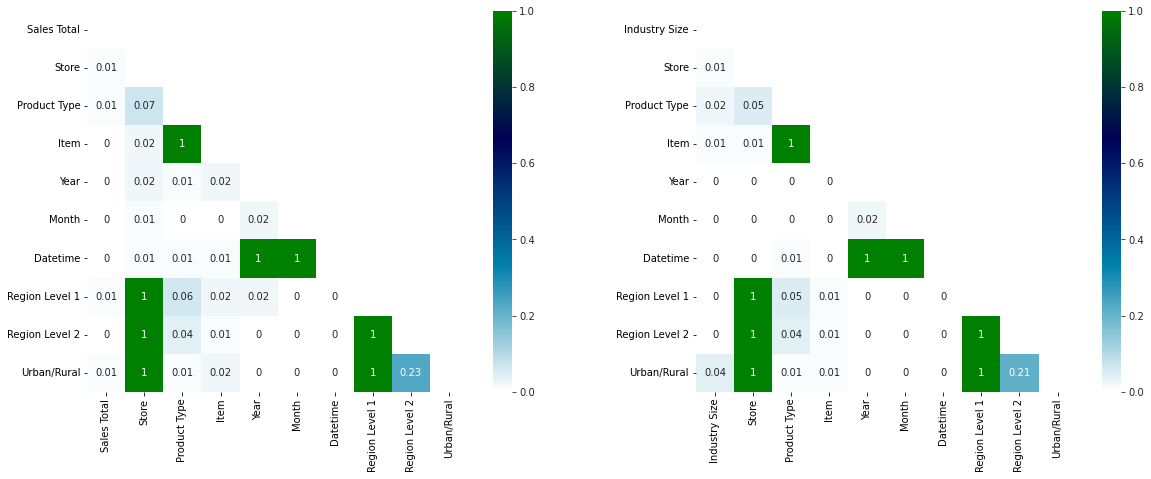

In [141]:
mask = np.zeros_like(df, dtype=bool)
mask[np.triu_indices_from(mask)] = True

mask2 = np.zeros_like(df2, dtype=bool)
mask2[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 2, figsize=(20, 7))

with sns.axes_style("white"):
    ax = sns.heatmap(df, mask=mask, vmin=0.0, vmax=1, square=True, ax=axes[0], annot=True, cmap="ocean_r")
    ax = sns.heatmap(df2, mask=mask, vmin=0.0, vmax=1, square=True, ax=axes[1], annot=True, cmap="ocean_r")

plt.show();